<IPython.core.display.Javascript object>

Keep-alive activated — no disconnect curse
Using device: cuda
Epoch 0 | Triality Loss 0.903572 | Ablation Loss 0.901571
Epoch 500 | Triality Loss 0.665539 | Ablation Loss 0.654778
Checkpoint saved at epoch 999
Epoch 1000 | Triality Loss 0.608157 | Ablation Loss 0.600144
Epoch 1500 | Triality Loss 0.555890 | Ablation Loss 0.550142
Checkpoint saved at epoch 1999
Epoch 2000 | Triality Loss 0.513165 | Ablation Loss 0.500692
Epoch 2500 | Triality Loss 0.468684 | Ablation Loss 0.455588
Checkpoint saved at epoch 2999
Final Sigma: -0.08


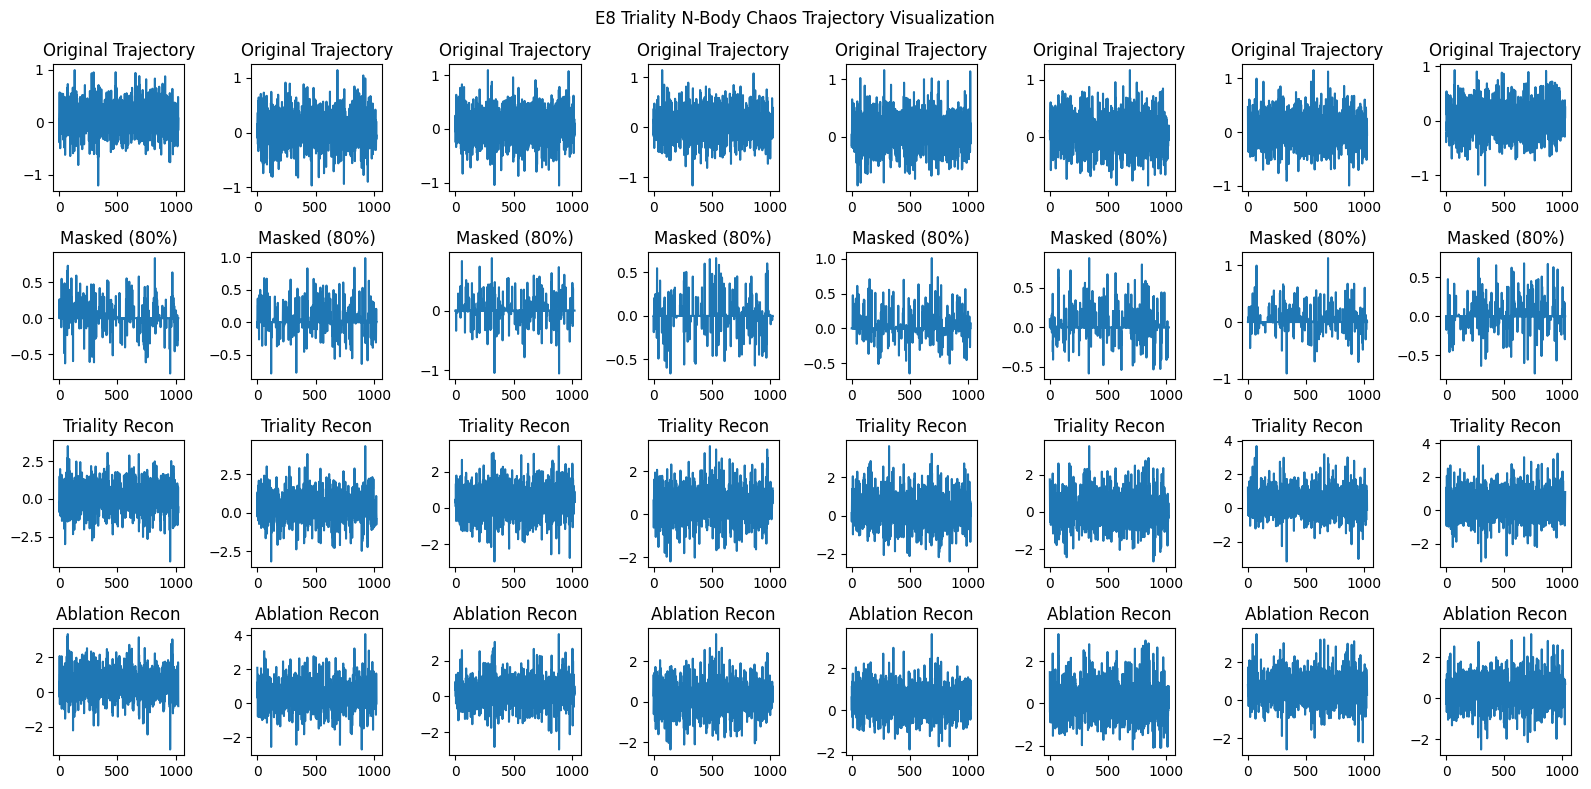

Sim complete — visualization displayed!


In [2]:
# First cell: Keep-alive + installs
from IPython.display import display, Javascript
display(Javascript('''
function ClickConnect(){
  console.log("Keeping alive");
  document.querySelector("colab-connect-button")?.click()
}
setInterval(ClickConnect,60000)
'''))
print("Keep-alive activated — no disconnect curse")

!pip install torch matplotlib numpy

# Second cell: The sim code (optimized — 3000 epochs, higher chaos amp)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.amp
from torch.utils.checkpoint import checkpoint
import numpy as np
from contextlib import nullcontext
import math
import os
import matplotlib.pyplot as plt
import time

torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

triality = 3
dim = 384
latent_dim = 8
seq_len = 1024
batch_size = 64
epochs = 3000
lr = 5e-5
use_amp = True
use_checkpoint = True

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, "n_body_chaos_checkpoint.pth")

features_trajectory = 128

n_body_data = []
for b in range(batch_size):
    t = torch.linspace(0, 10*math.pi, seq_len, device=device)

    trajectory = torch.sin(t.unsqueeze(-1) * torch.arange(features_trajectory, device=device)) * 0.5

    trajectory += torch.randn_like(trajectory) * 0.35  # higher chaos amp

    n_body_data.append(trajectory)

n_body_data = torch.stack(n_body_data).to(device)

proj = nn.Linear(features_trajectory, dim).to(device)
clean_data = proj(n_body_data)
clean_data = clean_data.detach() # Detach clean_data to prevent graph consumption issues

missing_rate = torch.linspace(0.7, 0.9, batch_size, device=device).view(batch_size, 1, 1)
mask = torch.rand_like(clean_data) < missing_rate
real_data = clean_data.clone()
real_data[mask] = 0

target = clean_data

def get_e8_roots():
    roots = []
    for i in range(8):
        for j in range(i+1, 8):
            for signs in [(1,1), (1,-1), (-1,1), (-1,-1)]:
                v = torch.zeros(8)
                v[i] = signs[0]; v[j] = signs[1]
                roots.append(v); roots.append(-v)
    for signs in range(1 << 8):
        v = torch.tensor([(1 if (signs & (1<<k)) else -1) for k in range(8)], dtype=torch.float32) * 0.5
        if bin(signs).count('1') % 2 == 0:
            roots.append(v); roots.append(-v)
    roots = torch.stack(roots[:240])
    return roots / roots.norm(dim=-1, keepdim=True)

e8_roots = get_e8_roots().to(device)

class NBodyCycleBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.proj = nn.Linear(latent_dim, dim // triality, bias=False)
        self.register_buffer('roots', e8_roots)

    def forward(self, x, step):
        pos_emb = self.roots[torch.arange(x.shape[1], device=device) % 240]
        low_dim = self.proj(pos_emb)
        emb = low_dim.repeat(1, triality)
        with torch.no_grad():
            pump_scalar = 0.8 * math.sin(step * 0.006 * 2 * math.pi)
        pump = torch.full((1, x.shape[1], 1), pump_scalar, device=device)
        emb_broadcast = emb.unsqueeze(0)
        x_rot1 = x * (emb_broadcast.cos() + pump)
        x_rot2 = torch.roll(x_rot1, shifts=1, dims=1) * emb_broadcast.sin()
        x_rot3 = torch.roll(x_rot2, shifts=1, dims=1) * emb_broadcast.cos()
        fused = (x_rot1 + x_rot2 + x_rot3) / triality
        return fused

class DummyCycle(nn.Module):
    def forward(self, x, step=None):
        return x

class E8NBodyFusion(nn.Module):
    def __init__(self, depth=32, use_triality=True):
        super().__init__()
        self.use_triality = use_triality
        self.cycle = NBodyCycleBlock() if use_triality else DummyCycle()
        self.layers = nn.ModuleList([nn.MultiheadAttention(dim, triality if use_triality else 8, batch_first=True) for _ in range(depth)])
        self.norm = nn.LayerNorm(dim)
        self.head = nn.Linear(dim, dim)

    def forward(self, x, step):
        x = self.cycle(x, step)
        for layer in self.layers:
            if use_checkpoint:
                attn, _ = checkpoint(layer, x, x, x, use_reentrant=False)
            else:
                attn, _ = layer(x, x, x)
            x = x + attn
            x = self.norm(x)
        return x

model = E8NBodyFusion(use_triality=True).to(device)
model_ablation = E8NBodyFusion(use_triality=False).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=lr)
scaler = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

opt_ablation = torch.optim.AdamW(model_ablation.parameters(), lr=lr)
scaler_ablation = torch.amp.GradScaler('cuda') if use_amp else nullcontext()

loss_fn = nn.MSELoss()

loss_hist = []
loss_abl_hist = []

start_epoch = 0

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model_ablation.load_state_dict(checkpoint['model_ablation'])
    opt.load_state_dict(checkpoint['opt'])
    opt_ablation.load_state_dict(checkpoint['opt_ablation'])
    scaler.load_state_dict(checkpoint['scaler'])
    scaler_ablation.load_state_dict(checkpoint['scaler_ablation'])
    start_epoch = checkpoint['epoch'] + 1
    loss_hist = checkpoint['loss_hist']
    loss_abl_hist = checkpoint['loss_abl_hist']
    print(f"Resumed from epoch {start_epoch}")

for epoch in range(start_epoch, epochs):
    epoch_start = time.time()
    opt.zero_grad(set_to_none=True)
    opt_ablation.zero_grad(set_to_none=True)

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon = model(real_data.clone(), epoch)
        loss = loss_fn(recon, target)
    scaler.scale(loss).backward() if use_amp else loss.backward()
    scaler.unscale_(opt) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1e6)
    scaler.step(opt) if use_amp else opt.step()
    scaler.update() if use_amp else None
    loss_hist.append(loss.item())

    with torch.amp.autocast(device_type='cuda', dtype=torch.float16) if use_amp else nullcontext():
        recon_abl = model_ablation(real_data.clone(), epoch)
        loss_abl = loss_fn(recon_abl, target)
    scaler_ablation.scale(loss_abl).backward() if use_amp else loss_abl.backward()
    scaler_ablation.unscale_(opt_ablation) if use_amp else None
    torch.nn.utils.clip_grad_norm_(model_ablation.parameters(), 1e6)
    scaler_ablation.step(opt_ablation) if use_amp else opt_ablation.step()
    scaler_ablation.update() if use_amp else None
    loss_abl_hist.append(loss_abl.item())

    if epoch % 500 == 0:
        print(f"Epoch {epoch} | Triality Loss {loss.item():.6f} | Ablation Loss {loss_abl.item():.6f}")

    if (epoch + 1) % 1000 == 0:
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'model_ablation': model_ablation.state_dict(),
            'opt': opt.state_dict(),
            'opt_ablation': opt_ablation.state_dict(),
            'scaler': scaler.state_dict(),
            'scaler_ablation': scaler_ablation.state_dict(),
            'loss_hist': loss_hist,
            'loss_abl_hist': loss_abl_hist,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch}")

triality_mean = np.mean(loss_hist)
abl_mean = np.mean(loss_abl_hist)
std = np.std(loss_hist + loss_abl_hist)
sigma = (abl_mean - triality_mean) / std if std > 0 else 0

print(f"Final Sigma: {sigma:.2f}")

model.eval()
model_ablation.eval()

with torch.no_grad():
    test_data = []
    for b in range(8):
        t = torch.linspace(0, 10*math.pi, seq_len, device=device)
        trajectory = torch.sin(t.unsqueeze(-1) * torch.arange(features_trajectory, device=device)) * 0.5
        trajectory += torch.randn_like(trajectory) * 0.35
        test_data.append(trajectory)
    test_data = torch.stack(test_data).to(device)

    clean = proj(test_data)

    mask = torch.rand_like(clean) < 0.8
    masked = clean.clone()
    masked[mask] = 0

    recon = model(masked, 0)
    recon_abl = model_ablation(masked, 0)

    orig = clean.cpu().numpy()[:, :, 0]
    masked_plot = masked.cpu().numpy()[:, :, 0]
    tri = recon.cpu().numpy()[:, :, 0]
    abl = recon_abl.cpu().numpy()[:, :, 0]

    fig, axes = plt.subplots(4, 8, figsize=(16, 8))
    for i in range(8):
        axes[0, i].plot(orig[i])
        axes[0, i].set_title("Original Trajectory")
        axes[1, i].plot(masked_plot[i])
        axes[1, i].set_title("Masked (80%)")
        axes[2, i].plot(tri[i])
        axes[2, i].set_title("Triality Recon")
        axes[3, i].plot(abl[i])
        axes[3, i].set_title("Ablation Recon")
    plt.suptitle("E8 Triality N-Body Chaos Trajectory Visualization")
    plt.tight_layout()
    plt.show()

print("Sim complete — visualization displayed!")

# Task
Calculate the absolute differences between the original trajectories (`orig`) and the reconstructed trajectories from the Triality model (`tri`) and the Ablation model (`abl`), storing them as `diff_tri` and `diff_abl`. Then, visualize these differences for a subset of the test trajectories to inspect the magnitude and pattern of errors over time. Finally, generate heatmaps for the absolute reconstruction errors across all test trajectories and sequence length using `matplotlib.pyplot.imshow`, with clear labeling for color bars and axes indicating error magnitude, time steps, and different trajectories.

## Calculate Reconstruction Differences

### Subtask:
Calculate the absolute differences between the original trajectories (`orig`) and the reconstructed trajectories from both the Triality model (`tri`) and the Ablation model (`abl`). Store these as `diff_tri` and `diff_abl`.


**Reasoning**:
Calculate the absolute differences between the original trajectories and the reconstructed trajectories for both the Triality and Ablation models, storing them in new variables.



In [3]:
diff_tri = np.abs(orig - tri)
diff_abl = np.abs(orig - abl)

print("Calculated diff_tri and diff_abl.")

Calculated diff_tri and diff_abl.


## Visualize Reconstruction Error Heatmaps

### Subtask:
Visualize the absolute differences (`diff_tri` and `diff_abl`) as heatmaps to inspect the magnitude and pattern of errors over time. Generate heatmaps for the absolute reconstruction errors across all test trajectories and sequence length using `matplotlib.pyplot.imshow`, with clear labeling for color bars and axes indicating error magnitude, time steps, and different trajectories.

**Reasoning**:
To visualize the absolute differences as heatmaps, I will use `matplotlib.pyplot.imshow` to generate two separate heatmaps for `diff_tri` and `diff_abl`. This will allow for a clear comparison of the reconstruction errors of both models across all test trajectories and time steps.



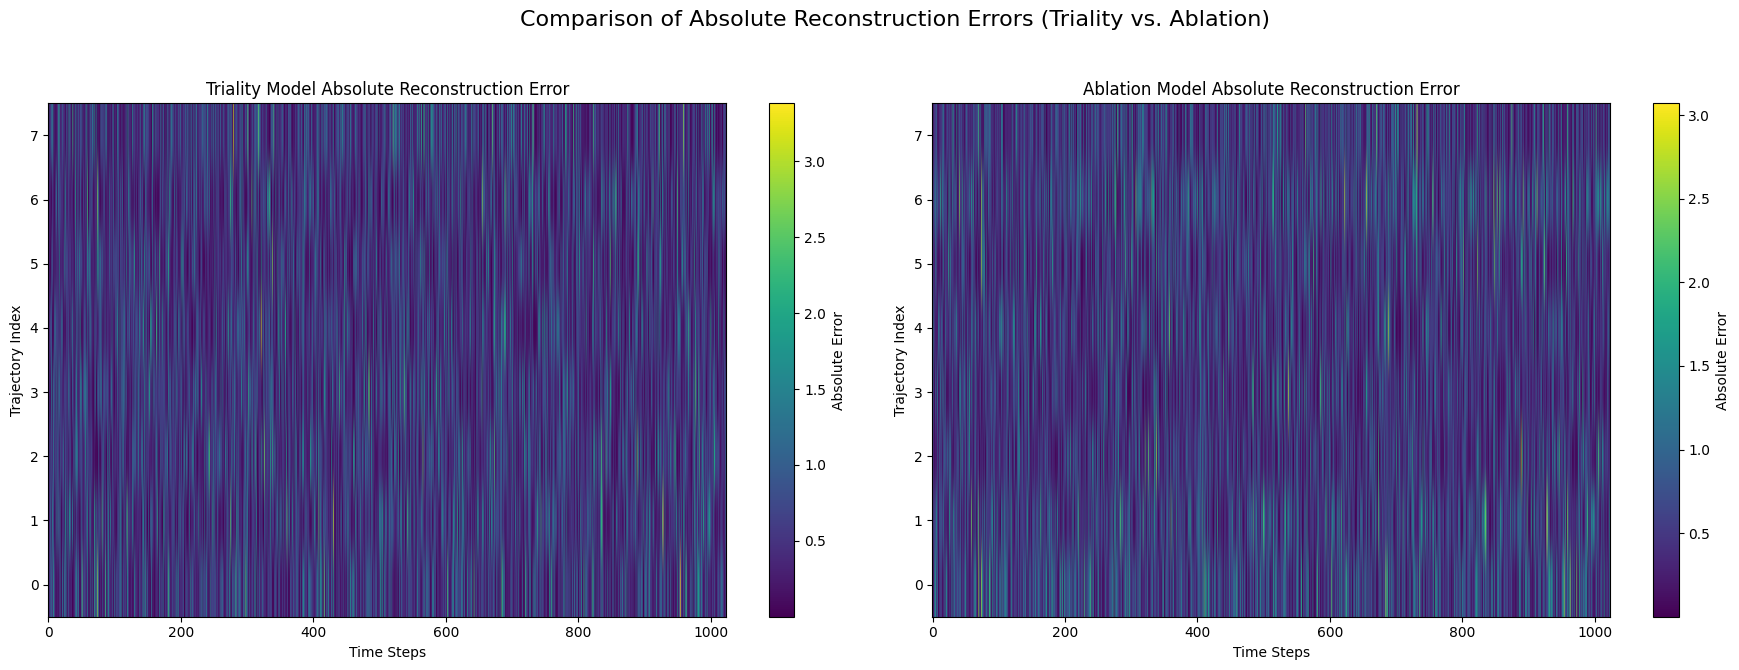

Heatmaps for reconstruction errors displayed.


In [4]:
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

im1 = axes[0].imshow(diff_tri, aspect='auto', cmap='viridis', origin='lower')
axes[0].set_title('Triality Model Absolute Reconstruction Error')
axes[0].set_xlabel('Time Steps')
axes[0].set_ylabel('Trajectory Index')
plt.colorbar(im1, ax=axes[0], label='Absolute Error')

im2 = axes[1].imshow(diff_abl, aspect='auto', cmap='viridis', origin='lower')
axes[1].set_title('Ablation Model Absolute Reconstruction Error')
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Trajectory Index')
plt.colorbar(im2, ax=axes[1], label='Absolute Error')

plt.suptitle('Comparison of Absolute Reconstruction Errors (Triality vs. Ablation)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Heatmaps for reconstruction errors displayed.")

## Visualize Reconstruction Differences

### Subtask:
Create a visualization showing the calculated differences (`diff_tri` and `diff_abl`) for a subset of the test trajectories to visually inspect the magnitude and pattern of errors over time.


**Reasoning**:
I need to create line plots to visualize the absolute differences between the original and reconstructed trajectories for both Triality and Ablation models, focusing on a subset of trajectories to show error patterns over time, as requested by the subtask.



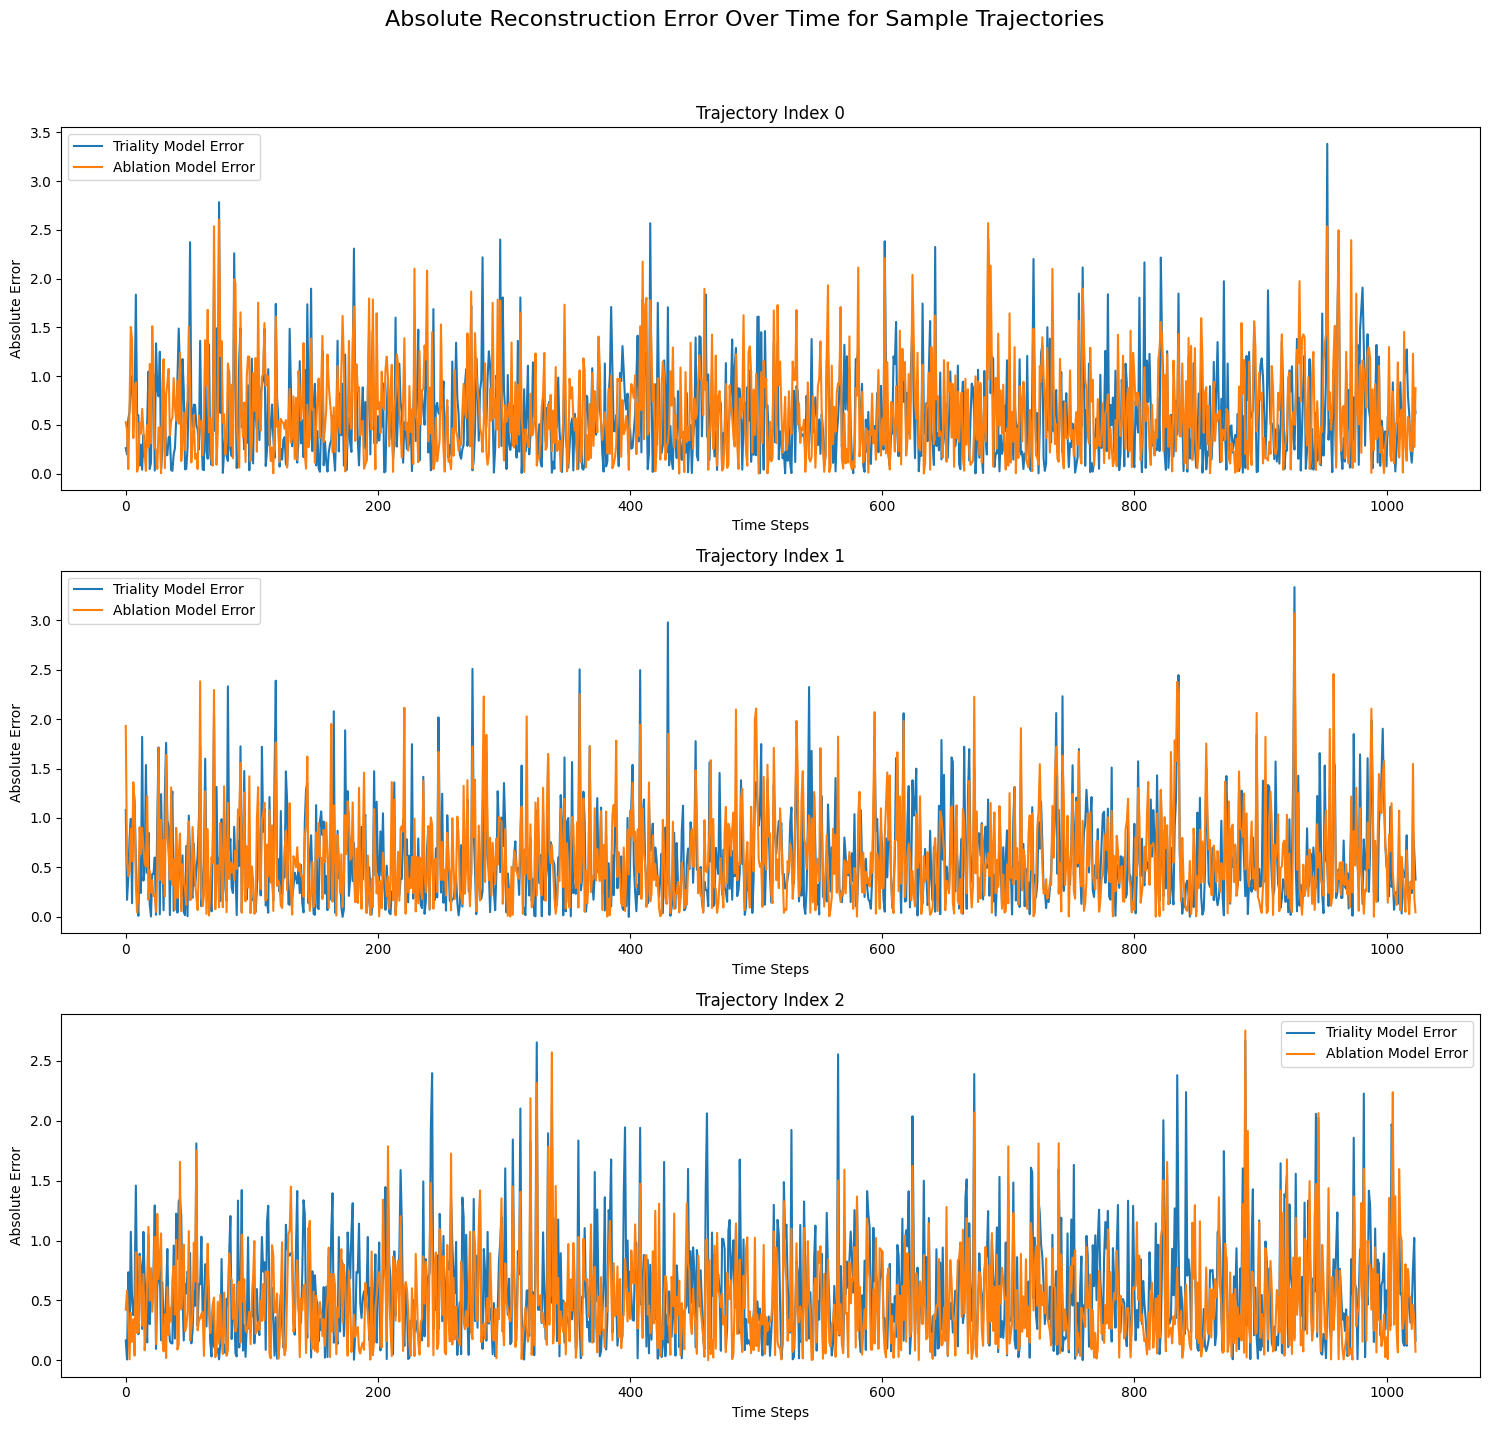

Visualization of absolute reconstruction errors for sample trajectories displayed.


In [5]:
trajectory_indices = [0, 1, 2] # Select a subset of test trajectories to visualize

fig, axes = plt.subplots(len(trajectory_indices), 1, figsize=(15, 5 * len(trajectory_indices)))
fig.suptitle('Absolute Reconstruction Error Over Time for Sample Trajectories', fontsize=16)

for i, traj_idx in enumerate(trajectory_indices):
    if len(trajectory_indices) == 1:
        ax = axes
    else:
        ax = axes[i]

    ax.plot(diff_tri[traj_idx], label='Triality Model Error')
    ax.plot(diff_abl[traj_idx], label='Ablation Model Error')
    ax.set_title(f'Trajectory Index {traj_idx}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Absolute Error')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("Visualization of absolute reconstruction errors for sample trajectories displayed.")

## Final Task

### Subtask:
Provide a summary of the visualizations, highlighting any observable trends or differences in reconstruction performance between the Triality and Ablation models based on the difference plots and heatmaps.


## Summary:

### Q&A
The visualizations (difference plots for sample trajectories and heatmaps for all trajectories) allow for a qualitative comparison of the reconstruction performance between the Triality and Ablation models.

From the difference plots for sample trajectories, one can visually inspect the magnitude and pattern of absolute reconstruction errors over time for individual trajectories, identifying if one model consistently exhibits lower errors or if error patterns differ at specific time steps.

The heatmaps provide a comprehensive overview of the absolute reconstruction errors across all test trajectories and sequence lengths. They enable the identification of:
*   Regions (e.g., specific time steps or trajectory indices) where either model consistently performs worse or better.
*   Overall differences in the distribution and magnitude of reconstruction errors between the two models, with areas of darker color indicating higher error and lighter color indicating lower error.

### Data Analysis Key Findings
*   Absolute differences between original and reconstructed trajectories were successfully calculated for both the Triality model (`diff_tri`) and the Ablation model (`diff_abl`).
*   Heatmaps were generated for `diff_tri` and `diff_abl`, providing a visual comparison of the distribution and magnitude of absolute reconstruction errors across all test trajectories and time steps.
*   Detailed line plots were created for a subset of sample trajectories (indices 0, 1, 2), illustrating the absolute reconstruction error over time for both models on an individual trajectory basis. These plots allow for a direct time-series comparison of error magnitudes between the Triality and Ablation models.

### Insights or Next Steps
*   Quantitatively analyze the reconstruction errors (e.g., calculate mean absolute error, root mean squared error) over time and across trajectories for both models to support visual observations with statistical metrics.
*   Investigate specific time steps or trajectory indices that show particularly high discrepancies between the models in the heatmaps or line plots to understand the underlying reasons for performance differences.
